In [20]:
library(dplyr)
source("~/sc-online/utils.R")

manifest = read.table("~/Calico_Macosko_PD_GSA_Terra_Manifest_20240220.tsv", sep='\t',header=T,skip=0)

manifest$donor_id = sapply(manifest$entity.sample_id, function(x) gsub("_1$", "", x))
manifest$sex = manifest$Sex
manifest$age = manifest$Age 
manifest$participant_id = ifelse(
    manifest$CORRECT.donor =='', 
    manifest$collaborator_participant_id,
    manifest$CORRECT.donor
)
manifest$case_control = ifelse(manifest$Disease == 'Control', 'ctr', 'pd')

donor_disease_map = setNames(manifest$case_control, manifest$donor_id)


The task here is simple <br>

(1) load all the `Expression_table.tsv`s for each library <br>
(2) Get the donor IDs for these cell barcodes. <br>
    (a) Toss the ones that are unassignable <br>
    (b) get fraction assignable overall, compare to fraction of droples with viral transcripts that are assignable <br>
(3) For each virus of interest, do the PD patients have a higher ratio of than control? 

In [2]:
base_dir = '/mnt/accessory/seq_data/calico'
file_pattern = 'Expression_table.tsv'

# refseq|NC_043329|12859nt|Bracoviriform
# refseq|NC_022518|9472nt|Human
# refseq|NC_003630|6357nt|Pepper
# refseq|NC_008168|104710nt|Choristoneura
# refseq|NC_032111|163005nt|BeAn
# refseq|NC_001550|8557nt|Mason-Pfizer
# refseq|NC_005856|94800nt|Escherichia
# refseq|NC_018464|927nt|Shamonda

microbes_of_interest = list(
    'NC_043329'
    , 'NC_022518'
    , 'NC_003630'
    , 'NC_008168'
    , 'NC_032111'
    , 'NC_001550'
    , 'NC_005856'
    , 'NC_018464'
)

# List all files in the directory and its subdirectories
all_files = list.files(path = base_dir, pattern = file_pattern, recursive = TRUE, full.names = TRUE)

# Print the directories containing the file
dirs_with_file <- dirname(all_files)
print(dirs_with_file)

names(all_files) = sapply(all_files, function(x){return(basename(dirname(x)))})

[1] "/mnt/accessory/seq_data/calico/pCalicoPDsHSrSNiPoold230719CD"
[2] "/mnt/accessory/seq_data/calico/pCalicoPDsHSrSNiPoold230719ED"
[3] "/mnt/accessory/seq_data/calico/pCalicoPDsHSrSNiPoold230719GD"
[4] "/mnt/accessory/seq_data/calico/pCalicoPDsHSrSNiPoold230719ID"
[5] "/mnt/accessory/seq_data/calico/pCalicoPDsHSrSNiPoold230719J1"
[6] "/mnt/accessory/seq_data/calico/pCalicoPDsHSrSNiPoold230719J2"
[7] "/mnt/accessory/seq_data/calico/pCalicoPDsHSrSNiPoold230719JD"
[8] "/mnt/accessory/seq_data/calico/pCalicoPDsHSrSNiPoold230719K1"


In [3]:
expr_dfs = list()
vireo_dfs = list()
grouped_dfs = list()
for (lib in names(all_files)){
    vireo_df = read.table(file.path(base_dir, lib, "GEX_vireo/donor_ids.tsv"), header = TRUE, sep = '\t')

    vireo_df = vireo_df[!vireo_df$donor_id %in% c('unassigned', 'doublet'),]
    vireo_df = vireo_df[vireo_df$prob_max >= 0.9,]
    rownames(vireo_df) = vireo_df$cell

    expr_df_orig = read.table(all_files[[lib]], header = TRUE, sep = '\t')
    colnames(expr_df_orig) = sapply(colnames(expr_df_orig), function(x){paste0(x, "-1")})
    expr_df_orig$virus_id = sapply(expr_df_orig$gene, function(x){return(strsplit(x, split = '\\|')[[1]][[2]])})
    expr_df = expr_df_orig[expr_df_orig$virus_id %in% microbes_of_interest, ]
    rownames(expr_df) = expr_df$gene
    expr_df = expr_df[, colnames(expr_df) %in% vireo_df$cell]

    expr_dfs[[lib]] = expr_df
    vireo_dfs[[lib]] = vireo_df
}


In [37]:
# now for each library, for each donor, 
# count the viruses of each type 

for (lib in names(all_files)){
    vireo_df_orig = vireo_dfs[[lib]]
    
    donor_cell_map = setNames(vireo_df$donor_id, vireo_df$cell)
    
    expr_df = expr_dfs[[lib]]
    #expr_df$virus_id = sapply(rownames(expr_df), function(x){return(strsplit(x, split = '\\|')[[1]][[2]])})
    expr_df_t = as.data.frame(t(expr_df))
    #expr_df_t$donor_id = sapply(rownames(expr_df_t), function(x){return(donor_cell_map[[x]])})


    vireo_df = vireo_df_orig[rownames(expr_df_t),]
    merged_df = cbind(expr_df_t, vireo_df)

    # columns should be donor_id, an anything beginning with the string refseq
    virus_cols = colnames(expr_df_t)
    cols = c('donor_id', virus_cols)

    grouped_df = (
            merged_df[, cols]
            %>% group_by(donor_id)
            %>% summarise(
                across(everything(), 
                    list(
                        sum = sum, 
                        frac = ~round(sum(.)/n(), 2)), 
                        .names = "{.col}_{.fn}"), 
                n_cells_with_virus= n()
            )
    )

    sum_cols = colnames(grouped_df)[grepl('_sum$', colnames(grouped_df))]
    herv_cols = sum_cols[grepl('NC_022518',sum_cols)]
    grouped_df$sum_herv = rowSums(grouped_df[herv_cols])

    grouped_df$n_cells = sapply(grouped_df$donor_id, function(x){
        return(nrow(vireo_df_orig[vireo_df_orig$donor_id == x,]))
    })
    grouped_df$case_control = donor_disease_map[grouped_df$donor_id]
    grouped_df$count_herv_gte0 = sapply(grouped_df$donor_id, function(x){
        herv_cols_merged = colnames(merged_df)[grepl('NC_022518',colnames(merged_df))]
        if (length(herv_cols_merged) == 0 | is.null(herv_cols_merged)){
            return(0)
        }
        return(sum(merged_df[merged_df$donor_id == x, herv_cols_merged] > 0))
    })
    grouped_df$frac_herv_gte0 = round(grouped_df$count_herv_gte0 / grouped_df$n_cells, 3)
    grouped_df$library = lib
    grouped_dfs[[lib]] = grouped_df[,
        c('library', 'donor_id', 'case_control', 'n_cells', 'sum_herv', 'count_herv_gte0', 'frac_herv_gte0')
    ]
}


In [38]:
herv_df = do.call(rbind, grouped_dfs)

In [39]:
herv_df

,library,donor_id,case_control,n_cells,sum_herv,count_herv_gte0,frac_herv_gte0
,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<dbl>
pCalicoPDsHSrSNiPoold230719CD.1,pCalicoPDsHSrSNiPoold230719CD,206954930010_R03C02,pd,4,0,0,0.000
pCalicoPDsHSrSNiPoold230719CD.2,pCalicoPDsHSrSNiPoold230719CD,206954930010_R07C01,pd,440,0,0,0.000
pCalicoPDsHSrSNiPoold230719CD.3,pCalicoPDsHSrSNiPoold230719CD,206954930010_R08C01,pd,1354,43,43,0.032
pCalicoPDsHSrSNiPoold230719CD.4,pCalicoPDsHSrSNiPoold230719CD,206954930011_R11C01,pd,9,0,0,0.000
pCalicoPDsHSrSNiPoold230719CD.5,pCalicoPDsHSrSNiPoold230719CD,206954930011_R11C02,ctr,399,0,0,0.000
pCalicoPDsHSrSNiPoold230719CD.6,pCalicoPDsHSrSNiPoold230719CD,206954930060_R07C01,pd,1134,28,25,0.022
pCalicoPDsHSrSNiPoold230719ED.1,pCalicoPDsHSrSNiPoold230719ED,206954930010_R06C01,ctr,929,0,0,0.000
pCalicoPDsHSrSNiPoold230719ED.2,pCalicoPDsHSrSNiPoold230719ED,206954930093_R10C01,pd,620,2,2,0.003
pCalicoPDsHSrSNiPoold230719ED.3,pCalicoPDsHSrSNiPoold230719ED,207758480019_R01C01,pd,1095,35,33,0.030


In [45]:
herv_df_ctr = herv_df[herv_df$case_control == 'ctr',]
herv_df_pd = herv_df[herv_df$case_control == 'pd',]

mean(herv_df$frac_herv_gte0)
mean(herv_df_ctr$frac_herv_gte0)
mean(herv_df_pd$frac_herv_gte0)


[1] 0.0054

[1] 0.005090909

[1] 0.0055

In [42]:
mean(herv_df[herv_df$case_control == 'ctr',]$n_cells)
mean(herv_df[herv_df$case_control == 'pd',]$n_cells)

[1] 937.2727

[1] 863.2059

In [46]:
sum(herv_df$sum_herv > 0) / nrow(herv_df)
sum(herv_df_ctr$sum_herv > 0) / nrow(herv_df_ctr)
sum(herv_df_pd$sum_herv > 0) / nrow(herv_df_pd)

[1] 0.5777778

[1] 0.5454545

[1] 0.5882353

In [47]:
lib_ctr_fracs = list()
lib_pd_fracs = list()
for (lib in unique(herv_df$library)){
    herv_df_lib = herv_df[herv_df$library == lib,]
    herv_df_lib_ctr = herv_df_ctr[herv_df_ctr$library == lib,]
    herv_df_lib_pd = herv_df_pd[herv_df_pd$library == lib,]
    lib_ctr_fracs[[lib]] = mean(herv_df_lib_ctr$frac_herv_gte0)
    lib_pd_fracs[[lib]] = mean(herv_df_lib_pd$frac_herv_gte0)
}

In [51]:
mean(as.numeric(lib_ctr_fracs))
mean(as.numeric(lib_pd_fracs))

[1] 0.006

[1] 0.005372917

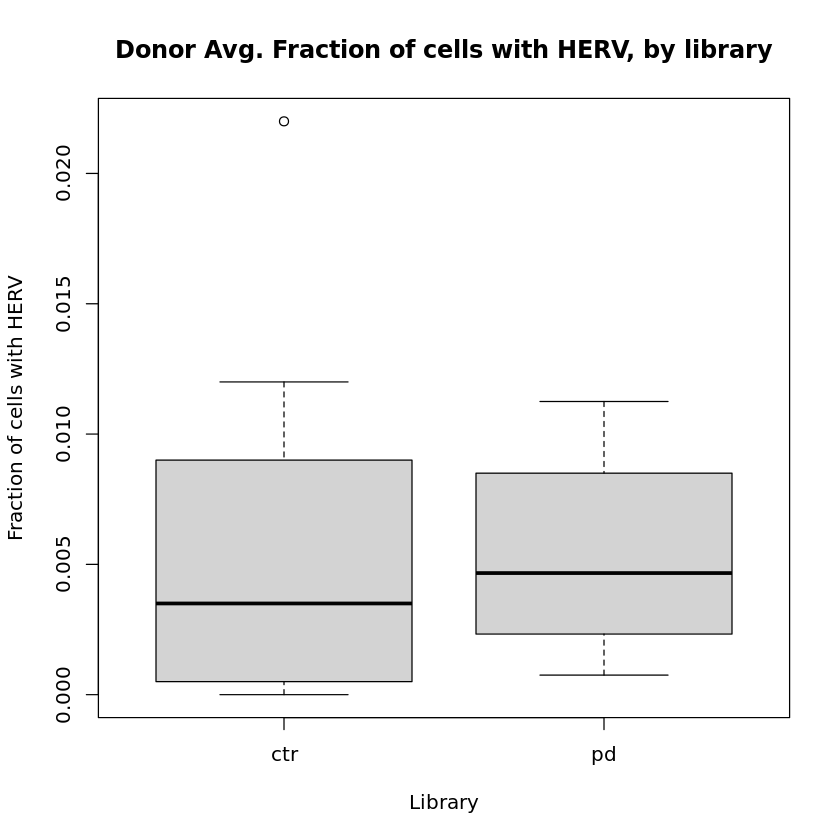

In [52]:
boxplot(
    as.numeric(lib_ctr_fracs), as.numeric(lib_pd_fracs), names = c('ctr', 'pd'), 
    ylab = 'Fraction of cells with HERV', xlab = 'Library', main = 'Donor Avg. Fraction of cells with HERV, by library')

In [53]:
wilcox.test(as.numeric(lib_ctr_fracs), as.numeric(lib_pd_fracs))

Warning message in wilcox.test.default(as.numeric(lib_ctr_fracs), as.numeric(lib_pd_fracs)):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  as.numeric(lib_ctr_fracs) and as.numeric(lib_pd_fracs)
W = 27.5, p-value = 0.674
alternative hypothesis: true location shift is not equal to 0


In [54]:
sum(c(475,
163,
20,
146,
263,
483))

[1] 1550

In [55]:
1550 / (1550 + 334 + 299)

[1] 0.7100321

In [ ]:
206954930010_R02C01	522
206954930011_R11C02	225
206954930093_R08C01	81
207762950086_R06C02	153
207762950086_R07C02	273
207762950086_R11C01	513
doublet	39
unassigned	640

In [57]:
(513 + 273 + 153 + 81 + 225 + 522)

[1] 1767

In [56]:
(513 + 273 + 153 + 81 + 225 + 522) / (513 + 273 + 153 + 81 + 225 + 522 + 679)

[1] 0.7224039